In [1]:
#importing dependencies

import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

from graph import *
from model import *

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Loading Data

In [2]:
g = np.load('facebook.npz')

In [3]:
g.files

['edges', 'features', 'target']

In [4]:
# Get the edges, features and target(label) of the graph
edges = g['edges']
X = g['features']
target = g['target']

In [5]:
# Get adjacency matrix
A = get_adj_mat(edges)

In [6]:
# Normalised the adjacency matrix
A = get_adj_mat_hat(A)

Instructions for updating:
Use `tf.linalg.matmul` instead


In [7]:
X.shape

(22470, 128)

In [8]:
# Number of nodes
N = X.shape[0]

In [9]:
# Number of features
F = X.shape[1]

In [10]:
# Number of Classes
num_classes = len(np.unique(target))

In [11]:
print("Number of nodes: {}\nNumber of features: {}\nNumber of classes: {}".format(N,F,num_classes))

Number of nodes: 22470
Number of features: 128
Number of classes: 4


# Select examples for training, validation, and test then set the mask

In [12]:
def split_data(target, N, limit=400,val_num=5000):
    '''
    Get the index of train, validation, and test data
    '''
    label_counter = dict((l, 0) for l in target)
    train_idx = []
    test_num = N - limit*len(np.unique(target)) - val_num
    for i in range(len(target)):
        label = target[i]
        if label_counter[label]<limit:
            #add the example to the training data
            train_idx.append(i)
            label_counter[label]+=1
        
        #exit the loop once we found 400 examples for each class
        if all(count == limit for count in label_counter.values()):
            break
    
    #get the indices that do not go to traning data
    rest_idx = [x for x in range(len(target)) if x not in train_idx]
    #get the first val_num
    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

# Numbers of samples: Training: 1600, Validation: 4000, Test: 15870
train_idx,val_idx,test_idx = split_data(target,N)

In [13]:
#set the mask
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [14]:
# Convert the target with one-hot
target = to_categorical(target)

# Building and training a multi-layer GCN model

In [15]:
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs

In [16]:
model = GCN_model(F, N, num_classes)

In [17]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', weighted_metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 128)          0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 22470)]      0                                            
__________________________________________________________________________________________________
gcn_conv (GCNConv)              (None, 32)           4096        dropout[0][0]                    
                                                                 input_2[0][0]                

In [18]:
# Train model
validation_data = ([X, A], target, val_mask)
model.fit([X, A],
          target,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False
 )

Epoch 1/200
1/1 [==============================] - 7s 7s/step - loss: 0.1020 - acc: 0.2206 - val_loss: 0.2937 - val_acc: 0.3740
Epoch 2/200
1/1 [==============================] - 1s 1s/step - loss: 0.0950 - acc: 0.3137 - val_loss: 0.2760 - val_acc: 0.5142
Epoch 3/200
1/1 [==============================] - 1s 1s/step - loss: 0.0895 - acc: 0.4519 - val_loss: 0.2621 - val_acc: 0.5786
Epoch 4/200
1/1 [==============================] - 1s 964ms/step - loss: 0.0855 - acc: 0.4975 - val_loss: 0.2499 - val_acc: 0.6182
Epoch 5/200
1/1 [==============================] - 1s 1s/step - loss: 0.0825 - acc: 0.5337 - val_loss: 0.2388 - val_acc: 0.6470
Epoch 6/200
1/1 [==============================] - 1s 1s/step - loss: 0.0791 - acc: 0.5656 - val_loss: 0.2277 - val_acc: 0.6850
Epoch 7/200
1/1 [==============================] - 1s 1s/step - loss: 0.0754 - acc: 0.6006 - val_loss: 0.2169 - val_acc: 0.7078
Epoch 8/200
1/1 [==============================] - 1s 1s/step - loss: 0.0724 - acc: 0.6244 - val_loss

1/1 [==============================] - 1s 1s/step - loss: 0.0226 - acc: 0.8888 - val_loss: 0.0635 - val_acc: 0.9122
Epoch 128/200
1/1 [==============================] - 1s 1s/step - loss: 0.0225 - acc: 0.8975 - val_loss: 0.0634 - val_acc: 0.9122
Epoch 129/200
1/1 [==============================] - 1s 1s/step - loss: 0.0230 - acc: 0.8938 - val_loss: 0.0632 - val_acc: 0.9128
Epoch 130/200
1/1 [==============================] - 1s 1s/step - loss: 0.0221 - acc: 0.8944 - val_loss: 0.0632 - val_acc: 0.9122
Epoch 131/200
1/1 [==============================] - 1s 1s/step - loss: 0.0223 - acc: 0.8919 - val_loss: 0.0633 - val_acc: 0.9124
Epoch 132/200
1/1 [==============================] - 1s 1s/step - loss: 0.0212 - acc: 0.9006 - val_loss: 0.0632 - val_acc: 0.9128
Epoch 133/200
1/1 [==============================] - 1s 1s/step - loss: 0.0221 - acc: 0.8956 - val_loss: 0.0627 - val_acc: 0.9134
Epoch 134/200
1/1 [==============================] - 1s 1s/step - loss: 0.0252 - acc: 0.8844 - val_loss:

In [19]:
losses = pd.DataFrame(model.history.history)

In [20]:
losses.head()

,loss,acc,val_loss,val_acc
0,0.101987,0.220625,0.293689,0.3740
1,0.094966,0.313750,0.276039,0.5142
2,0.089518,0.451875,0.262129,0.5786
3,0.085502,0.497500,0.249950,0.6182
4,0.082465,0.533750,0.238769,0.6470


<AxesSubplot:>

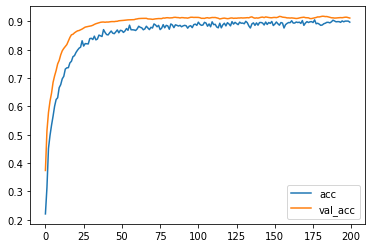

In [21]:
losses[['acc','val_acc']].plot()

<AxesSubplot:>

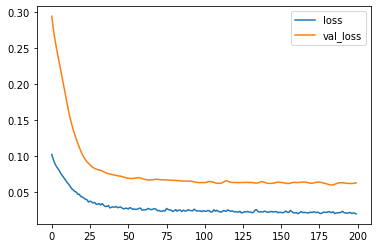

In [22]:
losses[['loss','val_loss']].plot()

# Evaluation

In [23]:
# Get the labels for test set
y_test = target[test_mask]

In [24]:
# Prediction of the whole graph
y_pred = model.predict([X, A],batch_size=N)

In [25]:
report = classification_report(np.argmax(y_test,axis=1), np.argmax(y_pred[test_mask],axis=1))
print('GCN Classification Report for test set: \n {}'.format(report))

GCN Classification Report for test set: 
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      2324
           1       0.93      0.90      0.92      4598
           2       0.93      0.92      0.93      4929
           3       0.93      0.93      0.93      4019

    accuracy                           0.91     15870
   macro avg       0.90      0.91      0.91     15870
weighted avg       0.92      0.91      0.91     15870



In [26]:
report = classification_report(np.argmax(target,axis=1), np.argmax(y_pred,axis=1))
print('GCN Classification Report for the whole graph: \n {}'.format(report))

GCN Classification Report for the whole graph: 
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      3327
           1       0.94      0.90      0.92      6495
           2       0.93      0.92      0.93      6880
           3       0.93      0.93      0.93      5768

    accuracy                           0.92     22470
   macro avg       0.91      0.92      0.91     22470
weighted avg       0.92      0.92      0.92     22470



# TSNE Plot

In [27]:
x_tsne = TSNE(n_components=2).fit_transform(y_pred)

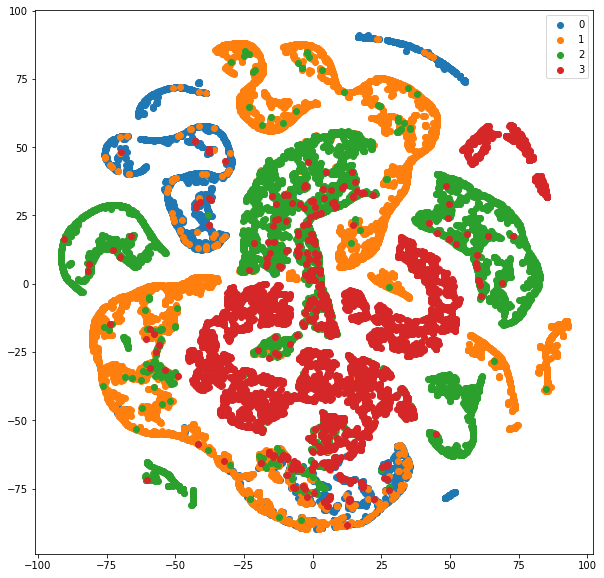

In [28]:
def plot_tSNE(target,x_tsne):
    color_map = np.argmax(target, axis=1)
    plt.figure(figsize=(10,10))
    for i in range(num_classes):
        indices = np.where(color_map==i)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=i)
    plt.legend()
    plt.show()
    
plot_tSNE(target,x_tsne)